## Nutrient Demands



### Introduction



Oromia

In [1]:
%pip install -q CFEDemands

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -q -r requirements.txt && echo "All requirements already satisfied." || echo "Installation failed. Check errors above."

All requirements already satisfied.


In [3]:
import pandas as pd
import cfe.regression as rgsn

### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [4]:
Ethiopia_Data = '189mt1h5lNgKcdu8EiaEDHLOr8COkD0bs2nGSAiA1vgA'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [46]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

SPREADSHEET_ID = "189mt1h5lNgKcdu8EiaEDHLOr8COkD0bs2nGSAiA1vgA"

x = read_sheets(SPREADSHEET_ID, sheet='Food Expenditures (2018-19)')
x = x[x['m'] == 'Oromia']  
x = x.set_index(['i','t','m','j']).squeeze()

p = (
    read_sheets(SPREADSHEET_ID, sheet='Food Prices (2018-19)')
    .query("m == 'Oromia'") 
    .set_index(['t','m','j','u'])
    .groupby(['t','m','j','u']).median()
    .xs('Kg', level="u")
    .squeeze()
    .unstack('j')
)

d = (
    read_sheets(SPREADSHEET_ID, sheet="Household Characteristics")
    .query("m == 'Oromia'")  
    .replace(np.nan, 0)
    .set_index(['i','t','m'])
)

common_goods = p.columns.intersection(x.index.get_level_values('j'))
p = p[common_goods].T
x = x[x.index.get_level_values('j').isin(common_goods)]

print("Oromia Data:")
display(d.head(), x.head(), p.head())

Oromia Data:


Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
4010102202007 2011-12 Oromia              0              1              0   
              2013-14 Oromia              0              2              0   
              2015-16 Oromia              0              1              1   
4010102202029 2011-12 Oromia              0              0              0   
              2013-14 Oromia              1              0              0   

                              Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
4010102202007 2011-12 Oromia              0              1              0   
              2013-14 Oromia              0              1              0   
              2015-16 Oromia              0              1              0   
4010102202029 2011-12 Oromia              0              0              1   
              2013-14 Oromia              0              0              1   

                              Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
4010102202007 2011-12 Oromia              0            0            0   
              2013-14 Oromia              0            1            0   
              2015-16 Oromia              0            0            1   
4010102202029 2011-12 Oromia              0            0            1   
              2013-14 Oromia              0            0            2   

                              Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
4010102202007 2011-12 Oromia            0            0            1   
              2013-14 Oromia            0            0            1   
              2015-16 Oromia            0            0            0   
4010102202029 2011-12 Oromia            1            0            0   
              2013-14 Oromia            0            1            0   

                              Males 31-50  Males 51-99  log HSize  
i             t       m                                            
4010102202007 2011-12 Oromia            0            1   1.386294  
              2013-14 Oromia            0            0   1.791759  
              2015-16 Oromia            1            0   1.609438  
4010102202029 2011-12 Oromia            1            0   1.386294  
              2013-14 Oromia            1            0   1.791759

i                   t        m       j          
040116010100105003  2018-19  Oromia  Banana          30.0
                                     Beef           200.0
                                     Berbere         60.0
                                     Butter/ghee     50.0
                                     Coffee          50.0
Name: Expenditure, dtype: float64

t,2018-19
m,Oromia
j,
Avocado,18.808847
Banana,16.823923
Barley,44.486867
Beef,342.682159
Beer,61.400349


Construct a regression object

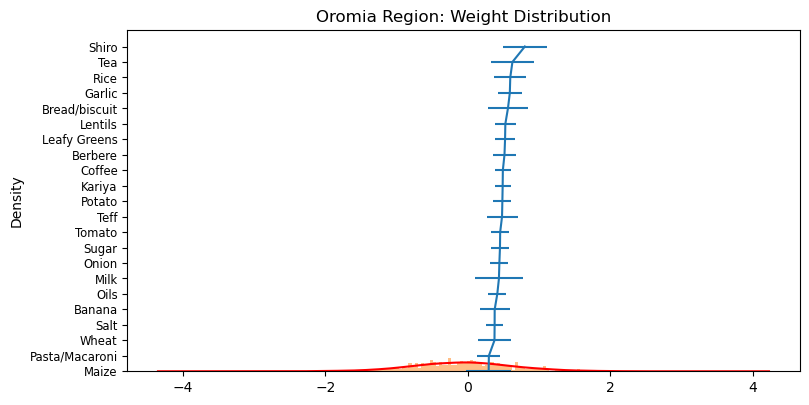

In [47]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

SPREADSHEET_ID = "189mt1h5lNgKcdu8EiaEDHLOr8COkD0bs2nGSAiA1vgA"

x = read_sheets(SPREADSHEET_ID, sheet='Food Expenditures (2018-19)')
x = x[x['m'] == 'Oromia']  # Filter for Oromia
x = x.set_index(['i','t','m','j']).squeeze()

y = np.log(x)

d = read_sheets(SPREADSHEET_ID, sheet="Household Characteristics")
d = d[d['m'] == 'Oromia']  
d.columns.name = 'k'
d = d.replace(np.nan, 0)
d.set_index(['i','t','m'], inplace=True)

r = rgsn.Regression(y=y, d=d)
ax = r.graph_beta()
r.get_beta()  
r.get_gamma() 

ax = r.get_w().plot.hist(bins=100, density=True, alpha=0.5)
r.get_w().plot.kde(ax=ax, color='red')
ax.set_title("Oromia Region: Weight Distribution")

r.to_pickle('oromia_estimates.rgsn')

### Additional Data



In [7]:
fct = read_sheets(Ethiopia_Data,sheet='FCT')

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [8]:
rdi = read_sheets(Ethiopia_Data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [48]:
r = rgsn.read_pickle('ethiopia_estimates.rgsn')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [49]:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1)

#### Budgets



Get food budget for all households, then find median budget:



In [50]:
import numpy as np

xhat = r.predicted_expenditures()

xbar = xhat.groupby(['i','t','m']).sum()

xref = xbar.quantile(0.5)  

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [51]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

qhat = qhat.loc[:,qhat.count()>0]

qhat_oromia = qhat[qhat.index.get_level_values('m') == 'Oromia']

print("Oromia Food Quantities:")
qhat_oromia

Oromia Food Quantities:


,,j,Banana,Barley,Beef,Beetroot,Berbere,Bread/biscuit,Butter/ghee,Carrot,Chick Pea,Coffee,...,Rice,Salt,Shiro,Soda,Sorghum,Sugar,Tea,Teff,Tomato,Wheat
i,t,m,,,,,,,,,,,,,,,,,,,,,
040116010100105003,2018-19,Oromia,1.527121,1.759305,0.870224,0.732004,0.376390,0.334597,0.200783,0.918194,0.974836,0.365485,...,1.585505,0.297332,0.685894,0.850870,5.717563,0.590413,0.240154,6.018812,1.419612,3.608533
040116010100105023,2018-19,Oromia,1.812365,2.540426,0.873071,0.813961,0.421360,0.395970,0.224329,0.801250,1.122226,0.414476,...,2.012112,0.327111,0.859137,1.020045,7.887033,0.737571,0.285669,6.455928,1.638774,4.690959
040116010100105038,2018-19,Oromia,0.935045,0.860490,0.492209,0.546561,0.222048,0.178068,0.128468,0.488363,0.591008,0.239921,...,0.877586,0.211343,0.403954,0.527234,3.261325,0.361291,0.133639,3.848858,0.874688,2.017229
040116010100105053,2018-19,Oromia,1.360639,0.910335,0.662429,0.631248,0.324345,0.294404,0.186859,0.681132,0.691257,0.315606,...,1.102382,0.244895,0.518998,0.689424,3.749519,0.488321,0.205543,4.544983,1.159738,2.603053
040116010100105063,2018-19,Oromia,0.801376,0.566733,0.417802,0.502645,0.201489,0.190950,0.117386,0.483761,0.506635,0.222726,...,0.942675,0.216954,0.341826,0.464861,2.966151,0.412966,0.145356,3.277236,0.797991,2.137491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
043535010100252271,2018-19,Oromia,2.111390,2.719892,1.054337,0.981097,0.517544,0.591043,0.402828,1.039521,1.447638,0.511439,...,2.709864,0.371228,0.985387,1.291393,8.430993,0.900423,0.335415,7.482042,2.042649,5.558972
043535010100252291,2018-19,Oromia,1.822019,2.168578,0.905588,0.895675,0.540849,0.423678,0.337743,0.924711,1.148588,0.479429,...,1.790177,0.337579,0.928513,1.125017,6.579653,0.781747,0.356136,5.771007,1.910559,3.859297
4.1602E+16,2018-19,Oromia,1.332692,1.544877,0.681053,0.716218,0.342735,0.290861,0.218261,0.683481,0.897528,0.345301,...,1.418504,0.281352,0.640715,0.765855,5.063509,0.565099,0.217378,5.135303,1.339725,2.976958


Finally, define a function to change a single price in the vector $p$:



In [13]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [14]:
%matplotlib inline

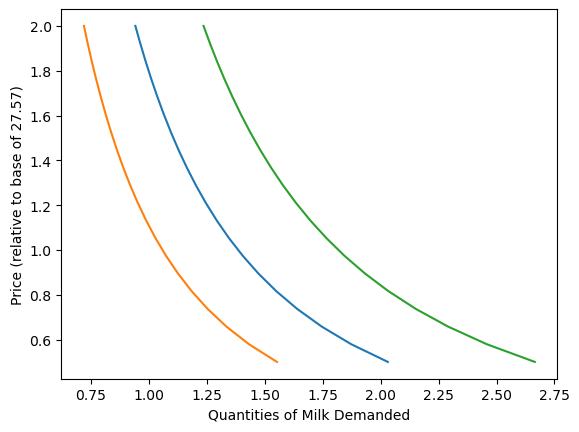

In [52]:
import matplotlib.pyplot as plt
import numpy as np

use = 'Milk'  

scale = np.linspace(.5, 2, 20)

plt.plot([r.demands(xref, my_prices(use, pbar[use] * s, pbar))[use] for s in scale], scale)

plt.plot([r.demands(xbar.quantile(0.25), my_prices(use, pbar[use] * s, pbar))[use] for s in scale], scale)

plt.plot([r.demands(xbar.quantile(0.75), my_prices(use, pbar[use] * s, pbar))[use] for s in scale], scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

plt.show()

#### Engel Curves



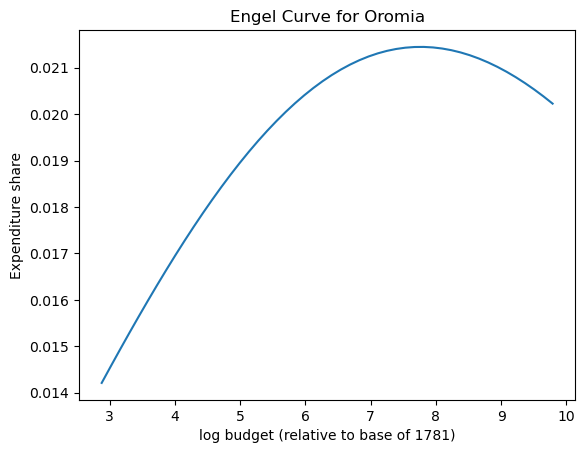

In [53]:
import numpy as np
import matplotlib.pyplot as plt

use = 'Milk'  
qhat_oromia_use = qhat_oromia[use]  

scale = np.geomspace(0.01, 10, 50)

fig, ax = plt.subplots()
ax.plot(np.log(scale * xref), [r.expenditures(s * xref, pbar)[use] / (s * xref) for s in scale])

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curve for Oromia')

plt.show()

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [17]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,...,Zinc,Fiber,Folate,Carbohydrate,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin K
j,,,,,,,,,,,,,,,,,,,,,
Avocado,1601.338432,20.00000,70,0,20.7,100,2.570,0,120.00,290.0,...,6.400,67.00,810.0,85.30000,17.38,520.0,4850.0,1.300,0.6700,210.0
Banana,890.000000,11.00000,30,0,1.0,87,4.000,0,50.00,270.0,...,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barley,3490.000000,123.00000,0,0,10.0,0,2.000,0,260.00,920.0,...,20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,3230.000000,249.00000,0,0,0.0,0,3.000,19,40.00,230.0,...,41.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beer,410.000000,3.00000,0,0,0.0,0,1.000,0,50.00,60.0,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beetroot,430.210325,16.10000,20,0,0.4,49,0.670,0,160.00,230.0,...,3.500,28.00,1090.0,95.60000,3.34,400.0,3250.0,0.400,0.3100,2.0
Berbere,74.869981,8.95625,0,0,0.0,1417,3.027,0,63.61,109.8,...,2.023,11.58,473.2,66.53175,10.24,265.9,2127.0,1.422,0.5494,0.0
Boye/Yam,970.000000,21.00000,0,0,50.0,120,2.000,0,80.00,260.0,...,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bread/biscuit,2740.000000,80.00000,0,0,0.0,0,0.000,0,100.00,270.0,...,9.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [54]:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Barley', 'Beef', 'Beetroot', 'Berbere', 'Bread/biscuit',
       'Butter/ghee', 'Coffee', 'Eggs', 'Fenugreek', 'Garlic',
       'Goat & mutton meat', 'Ground nuts', 'Injera', 'Leafy Greens', 'Maize',
       'Mango', 'Milk', 'Oils', 'Onion', 'Orange', 'Pasta/Macaroni', 'Potato',
       'Rice', 'Salt', 'Soda', 'Sorghum', 'Sugar', 'Tea', 'Teff'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [55]:
N = fct0.T@c0

N 

i,010101088800910017,010101088800910026,010101088800910029,010101088800910046,010101088800910054,010101088800910062,010101088800910070,010101088800910082,010101088800910093,010102088801010034,...,3.0714E+16,4.1602E+16,4.2828E+16,4.303E+16,5.01031E+16,5.0511E+16,6.0104E+16,7.0211E+16,7.06101E+16,7.10031E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,...,Amhara,Oromia,Oromia,Oromia,Somali,Somali,Benishangul-Gumuz,SNNP,SNNP,SNNP
n,,,,,,,,,,,,,,,,,,,,,
Energy,56193.451607,56631.188823,53000.109215,51490.584980,59322.645320,59359.539228,67654.349642,65249.202502,57079.797862,90193.472095,...,100714.067026,81722.499218,78456.684019,61495.813741,154144.670622,126393.731495,79380.971778,45058.170986,28757.599893,25742.408560
Protein,1813.764999,1811.856685,1702.538444,1660.749301,1871.629628,2013.278981,2270.239060,2127.052694,1957.884119,2899.967699,...,3106.170975,2709.342492,2673.122685,2098.906704,4735.691374,4059.277791,2590.522145,1607.479251,1059.181404,930.472118
Vitamin A,18247.713311,18986.229204,18633.356118,16685.013797,19088.800018,19500.767298,25247.686537,21912.203770,19774.082300,30625.044783,...,32063.377210,25132.804374,25763.900967,20704.364348,77746.732836,75131.986879,29319.749439,28992.084386,15027.490313,14495.178543
Vitamin D,90.179706,89.708493,77.667325,80.948565,80.197883,91.496458,106.661192,90.661699,85.148932,135.841834,...,161.501889,104.875343,117.114924,88.777930,478.123503,409.638162,114.726120,115.111451,87.591957,65.523924
Vitamin E,111.771172,109.670958,118.267590,106.803778,123.209927,123.611005,154.078138,136.964355,124.081446,196.264358,...,254.505708,228.494052,208.132258,182.059090,418.930401,412.025272,200.907974,161.722238,77.297738,82.889508
Vitamin C,2496.426895,2431.979001,1990.913136,2191.927366,2091.457252,2149.520171,3331.306212,2426.161410,2436.336625,3429.775124,...,3577.143842,2237.022808,2343.845281,1856.408118,4789.358203,4682.535676,2186.808892,2745.438552,1378.461213,1550.115880
Vitamin B-6,60.260992,60.413707,57.644408,55.171487,62.568850,66.290140,78.583831,71.582507,66.361477,95.904627,...,100.410792,86.276811,85.103178,67.955069,139.663444,130.535700,89.349156,56.052739,31.999263,31.883546


In [56]:
oromia_data = N.loc[:, N.columns.get_level_values('m') == 'Oromia']

oromia_data

i,040116010100105003,040116010100105023,040116010100105038,040116010100105053,040116010100105063,040116010100105077,040116010100105090,040116010100105106,040116010100105117,040116010100105127,...,043535010100252171,043535010100252191,043535010100252211,043535010100252231,043535010100252251,043535010100252271,043535010100252291,4.1602E+16,4.2828E+16,4.303E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,...,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia,Oromia
n,,,,,,,,,,,,,,,,,,,,,
Energy,91376.078546,111520.614946,55128.297353,68835.368542,50215.059491,108062.486373,71268.572090,65702.920200,72869.831407,60708.044624,...,55859.429384,68264.769515,96304.731744,113661.824924,122624.243376,131504.483191,106020.372207,81722.499218,78456.684019,61495.813741
Protein,3017.982721,3629.450263,1859.826053,2375.211860,1690.889547,3594.275696,2331.970766,2142.869250,2458.354902,1924.560555,...,1925.649556,2286.914513,3096.683312,3795.507379,3843.715287,4304.248714,3533.627769,2709.342492,2673.122685,2098.906704
Vitamin A,30504.421939,34683.742594,17419.586259,23816.143401,16442.928066,37096.539551,22460.713481,19645.683967,25953.428832,17944.949441,...,21354.681652,23555.491632,29114.558317,38318.648174,33971.848969,42158.935578,34400.239464,25132.804374,25763.900967,20704.364348
Vitamin D,141.103141,153.515222,78.128107,107.295538,80.356141,154.544258,100.726407,86.123009,115.094865,92.414113,...,90.868863,94.864679,115.672781,155.452506,135.570678,188.949263,133.121199,104.875343,117.114924,88.777930
Vitamin E,238.859739,282.734831,153.520804,197.820365,138.202556,296.683954,184.382796,168.351556,209.972751,141.264633,...,169.705113,203.548321,254.003602,323.951084,312.074621,342.810655,314.470249,228.494052,208.132258,182.059090
Vitamin C,2744.464814,3029.065629,1562.829766,2024.011238,1354.643267,3238.412297,2027.543159,1702.644703,2428.030519,1649.624574,...,1759.452183,1984.341251,2341.443454,3490.762201,3096.304375,3440.656354,3068.758007,2237.022808,2343.845281,1856.408118
Vitamin B-6,96.087221,111.990702,59.733587,76.411137,53.456893,115.825656,75.224540,67.354846,81.410515,59.520447,...,62.732561,73.132093,95.299044,122.048526,120.333234,133.365570,113.175697,86.276811,85.103178,67.955069


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [21]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

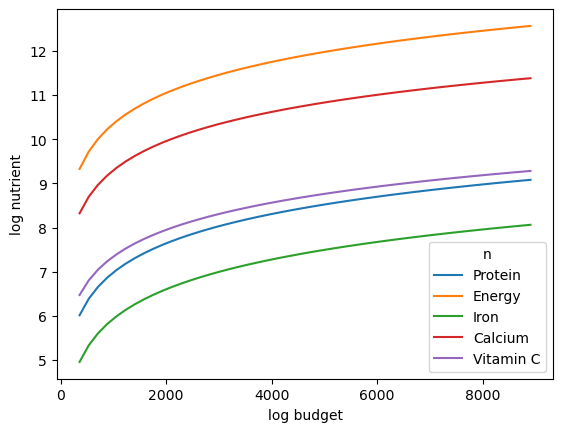

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

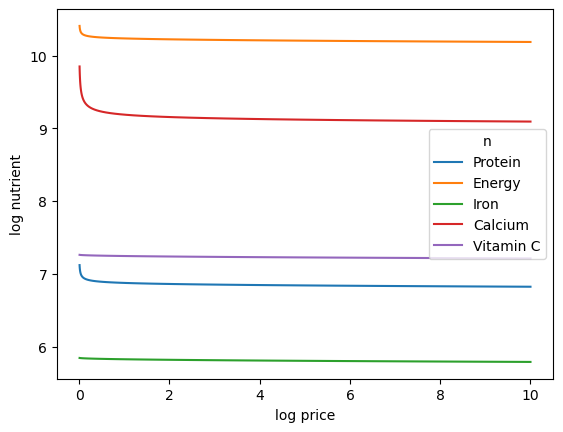

In [23]:
USE_GOOD = 'Milk'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [44]:
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [45]:
hh_rdi = rdi@dbar

hh_rdi

n
Energy           7629.418935
Protein           171.352093
Fiber             106.811865
Folate           1427.377082
Calcium          4482.446160
Carbohydrate      554.995937
Iron               47.710687
Magnesium        1227.683868
Niacin             54.196668
Phosphorus       3346.921983
Potassium       18678.545307
Riboflavin          4.257883
Thiamin             4.131288
Vitamin A        2836.428281
Vitamin B-12        8.564262
Vitamin B-6         4.700223
Vitamin C         261.073751
Vitamin E          53.273872
Vitamin K         343.995327
Zinc               34.263714
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [26]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



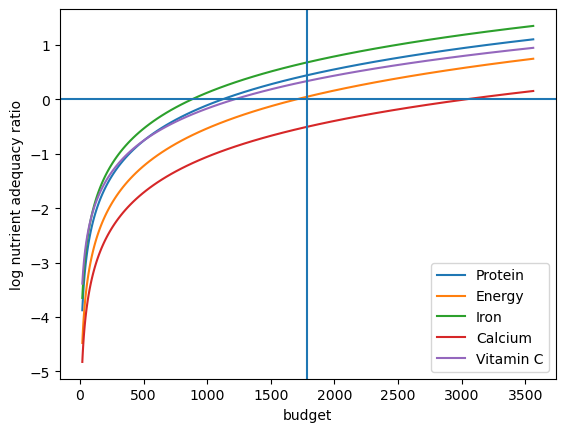

In [27]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

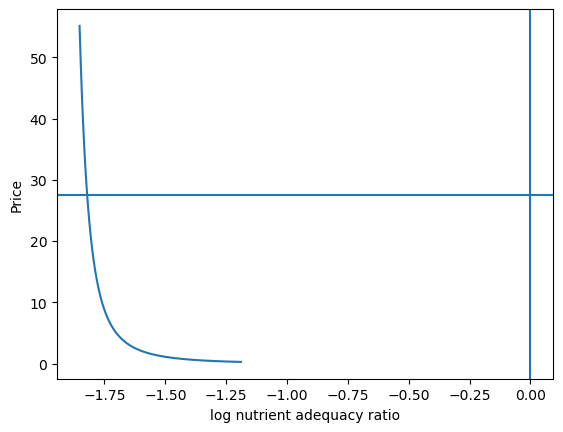

In [28]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Calcium'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

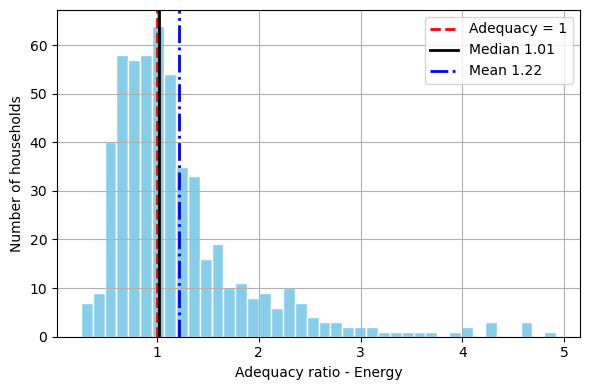

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

NUTRIENT = 'Energy'
days = 7

def phh(idx):
    _, t, m = idx
    return p.loc[:, (t, m)].reindex(pbar.index).fillna(pbar)

base_budget_oromia = xhat[xhat.index.get_level_values('m') == 'Oromia'].groupby(['i', 't', 'm']).sum().squeeze()

achieved, required = [], []
for hh in base_budget_oromia.index:
    q = r.demands(base_budget_oromia.loc[hh], phh(hh))
    f0, q0 = fct.align(q, axis=0, join='inner')
    achieved.append((f0.T @ q0).get(NUTRIENT, np.nan))
    required.append((rdi.loc[NUTRIENT] @ d.loc[hh, rdi.columns]) * days)

achieved_series = pd.Series(achieved, index=base_budget_oromia.index)
required_series = pd.Series(required, index=base_budget_oromia.index)

nar = (achieved_series / required_series).replace([np.inf, -np.inf], np.nan).dropna()
nar = nar[required_series > 0]

fig, ax = plt.subplots(figsize=(6, 4))
nar.hist(ax=ax, bins=40, edgecolor='white', color='skyblue')

ax.axvline(1, color='red', linestyle='--', lw=2, label='Adequacy = 1')
ax.axvline(nar.median(), color='black', lw=2, label=f'Median {nar.median():.2f}')
ax.axvline(nar.mean(), color='blue', lw=2, ls='-.', label=f'Mean {nar.mean():.2f}')

ax.set_xlabel(f'Adequacy ratio - {NUTRIENT}')
ax.set_ylabel('Number of households')
ax.legend()
plt.tight_layout()
plt.show()

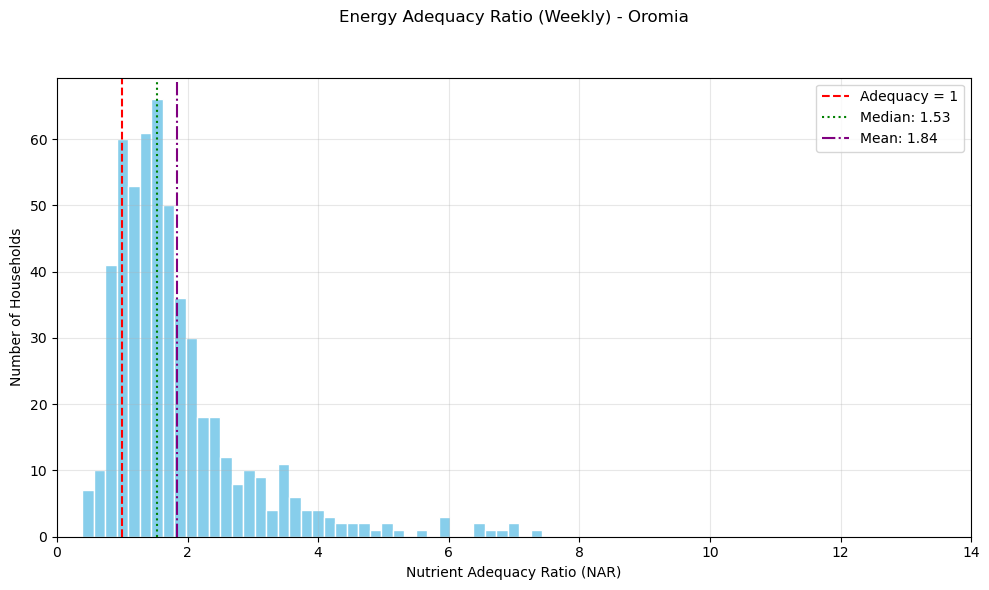

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

NUTRIENT = 'Energy'
days = 7
BUDGET_MULT = 1.1
PRICE_MULTIPLIER = {'Milk': 0.1, 'Leafy Greens': 0.1, 'Fenugreek': 0.1, 'Teff': 0.1}

def phh(idx):
    _, t, m = idx
    s = p.loc[:, (t, m)] if (t, m) in p.columns else pbar
    s = s.reindex(pbar.index).fillna(pbar)
    for g, mult in PRICE_MULTIPLIER.items():
        if g in s.index:
            s[g] *= mult
    return s

base_budget_oromia = xhat[xhat.index.get_level_values('m') == 'Oromia'].groupby(['i', 't', 'm']).sum().squeeze()

achieved, required = [], []
for hh in base_budget_oromia.index:
    q = r.demands(base_budget_oromia.loc[hh] * BUDGET_MULT, phh(hh))
    f0, q0 = fct.align(q, axis=0, join='inner')
    achieved.append((f0.T @ q0).get(NUTRIENT, np.nan))
    required.append((rdi.loc[NUTRIENT] @ d.loc[hh, rdi.columns]) * days)

nar = pd.Series(achieved, index=base_budget_oromia.index) / pd.Series(required, index=base_budget_oromia.index)
nar = nar.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(10, 6))

plt.hist(nar, 
         bins=40, 
         edgecolor='white', 
         color='skyblue',
         align='mid')

plt.axvline(1, color='red', linestyle='--', label='Adequacy = 1')
plt.axvline(nar.median(), color='green', linestyle=':', label=f'Median: {nar.median():.2f}')
plt.axvline(nar.mean(), color='purple', linestyle='-.', label=f'Mean: {nar.mean():.2f}')

plt.title('Energy Adequacy Ratio (Weekly) - Oromia', pad=40)
plt.xlabel('Nutrient Adequacy Ratio (NAR)')
plt.ylabel('Number of Households')
plt.legend()
plt.xlim(0, 14)
plt.grid(axis='both', alpha=0.3) 
plt.tight_layout()
plt.show()